In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import reduce
from scipy.stats import linregress
from scipy import fftpack
from scipy.signal import detrend
from scipy.optimize import root_scalar
from tqdm import tqdm
from scipy import special
from statsmodels.tsa.stattools import acf, pacf

## Single trait model

The $ODE$ of the single trait model regarding cell size is:
$$
\begin{dcases}
x(0) =  x_b  \\
\dot{x} = \omega_1 \left(x(t) + u\right)
\end{dcases}
$$
where $x_b$ is the cell size at birth. 

Then, we plug $x(t)$ into
$$
h(x(t)) = \omega_2 \left(1 + \frac{x(t)}{v}\right)
$$


Next, we use the found result for $h(x(t))$ to solve:
$$
\begin{dcases}
s(0) =  1  \\
\dfrac{\dot{s}(t)}{s(t)} = -h(x(t))
\end{dcases}
$$
Once we have $s(t)$ we can generate random division times from this distribution using the **inverse transform method**. Finally, we can deterministically propagate the solution to find $x(t)$. 


## Analytical solution of the differential equations
The result of two differential equations is:
$$
\begin{aligned}
s(t) &= \exp\left\{ \omega_2t \left(\frac{u}{v}-1\right) + \frac{\omega_2}{\omega_1}\left(\frac{u + x_b}{v}\right)(1-e^{\omega_1t})\right\} \\
\ln(s) &= \omega_2 t \left(\frac{u}{v}-1\right) + \frac{\omega_2}{\omega_1} \left(\frac{u+x_b}{v}\right) (1-e^{\omega_1 t})
\end{aligned}
$$

and $x(t)$ is given by
$$
x(t) = \left(x_b+u\right)e^{\omega_1 t}-u
$$


In [17]:
'''
Cell size evolution x(t)
'''
def x_function(t, u, xb, omega1 = 1):
    

    x = (xb+u)*np.exp(omega1*t)-u
    return x
    

'''
Hazard rate function h(t)
'''
def h(t, u, xb, omega2, omega1 = 1, v = 1):
    

    h = omega2*(1+x_function(t, u, xb, omega1)/v)
    return h    


'''
Logarithm of survival function s(t)
'''
def SDF(t, omega2, u, xb, omega1 = 1, v = 1):
    
    s = np.exp(omega2*t*(u/v - 1) + (omega2/omega1)*((u + xb)/v)*(1-np.exp(omega1*t)))
    return s


### Simulation of the single trait model

In [19]:
seriesLength = 5000 # Length of the time series
pointsPerEvolution = 200 # Number of points per cell division
sizesAtBirth = np.zeros(seriesLength)
timesAtBirth = np.zeros(seriesLength)
omega2 = 0.01
u = 0.9
# Initialize the cell size array
cellSizes = np.zeros(pointsPerEvolution*seriesLength)
xb = 0.5
t = 0
for i in range(seriesLength):
    timesAtBirth[i] = t
    sol = root_scalar(lambda t: SDF(t, omega2, u, xb) - np.random.uniform(0, 1), bracket=[0, 40], method='brentq')
    tau = sol.root
    times = np.linspace(0, tau, pointsPerEvolution)
    xt = x_function(times, u = 0.1, xb = xb, omega1 = 1)
    cellSizes[i*pointsPerEvolution:(i+1)*pointsPerEvolution] = xt
    sizesAtBirth[i] = xb
    xb = xt[-1]/2
    t += tau


allTimes = np.linspace(0, t, pointsPerEvolution*seriesLength)




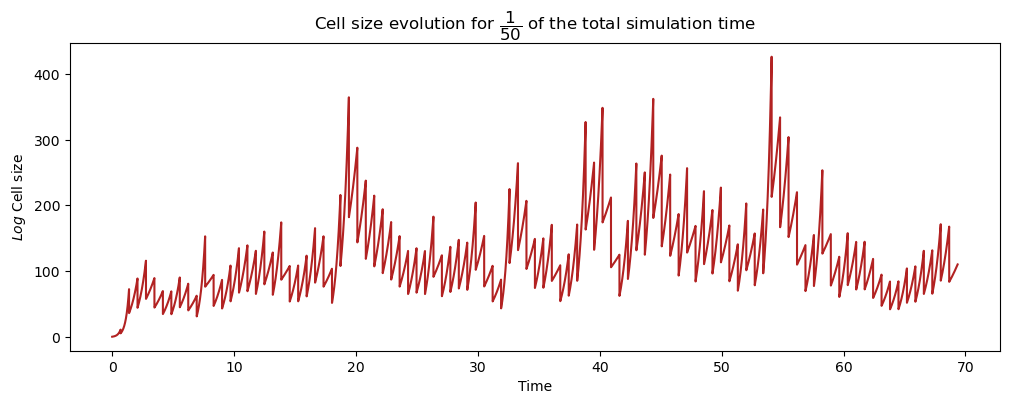

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
ax.plot(allTimes[:int(len(allTimes)/50)], cellSizes[:int(len(allTimes)/50)], color = 'firebrick')
ax.set_ylabel('$Log$ Cell size')
ax.set_xlabel('Time')
ax.set_title('Cell size evolution for $\dfrac{1}{50}$ of the total simulation time')
plt.show()

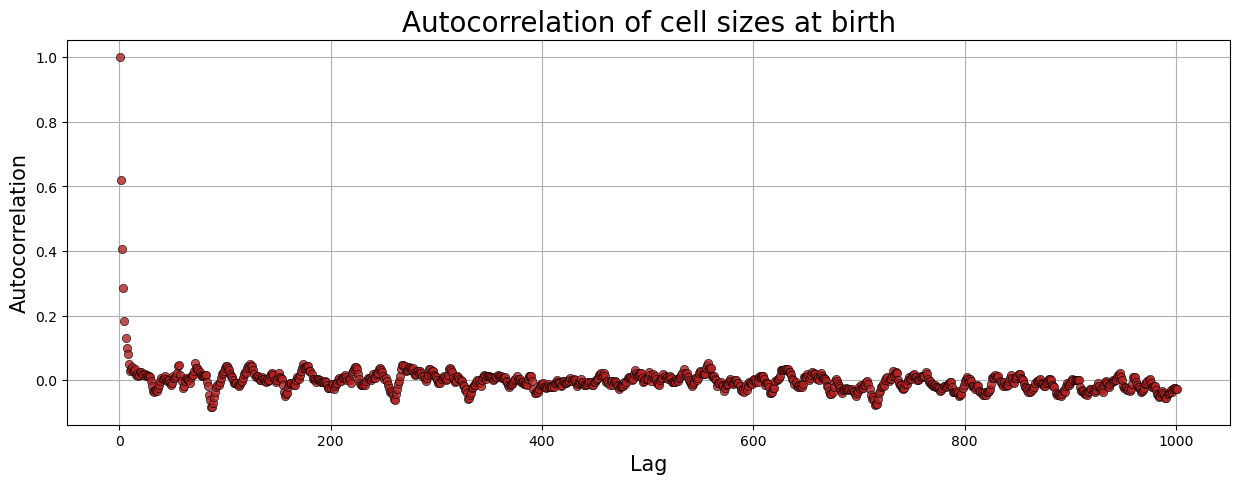

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
autocorrealtion = acf(sizesAtBirth, nlags = 1000)
#ax.set_xlim(left = -0.1)

ax.scatter(list(range(1, len(autocorrealtion) + 1)), autocorrealtion, color = 'firebrick', alpha = 0.8, edgecolor = 'black', linewidth = 0.5, zorder = 2)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
ax.grid(zorder = 1)

NameError: name 'cGt' is not defined

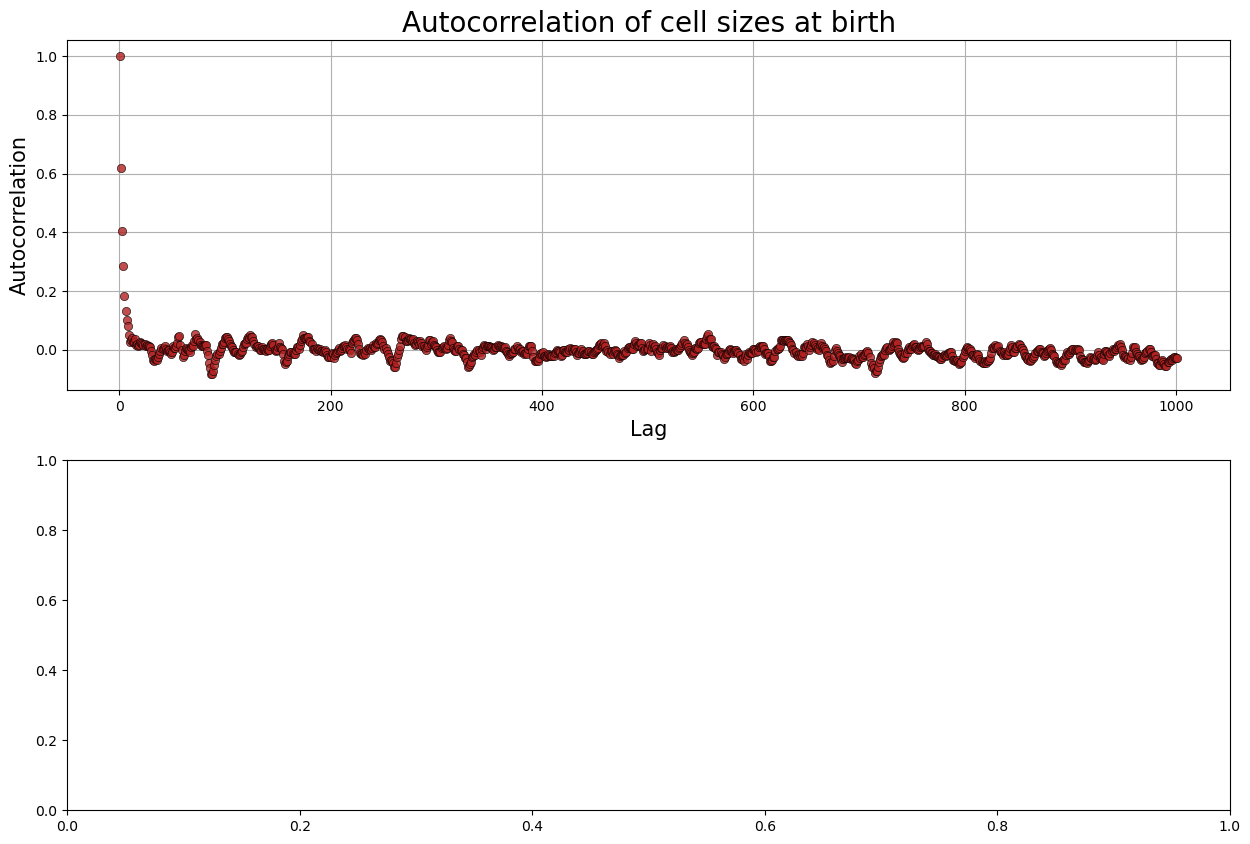

In [6]:
fig, ax1 = plt.subplots(2, 1, figsize = (15, 10))
ax, ax_ = ax1.flatten()
autocorrealtion = acf(sizesAtBirth, nlags = 1000)
#ax.set_xlim(left = -0.1)

ax.scatter(list(range(1, len(autocorrealtion) + 1)), autocorrealtion, color = 'firebrick', alpha = 0.8, edgecolor = 'black', linewidth = 0.5, zorder = 2)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
ax.grid(zorder = 1)

# The FFT of the signal
sig_fft = fftpack.fft(detrend(cGt))

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The return the corresponding frequencies
sample_freq = fftpack.fftfreq(len(cGt), d = 1)

# Plot the FFT power
ax_.plot(sample_freq[sample_freq > 0], power[sample_freq > 0], color = 'firebrick')
ax_.set_xlabel('Frequency [Hz]')
ax_.set_ylabel('Power')
ax_.set_title('Power spectrum of cell sizes at birth')
ax_.set_xlim(right = 0.2)
print('Dominant frequency: ', sample_freq[np.argmax(power[sample_freq > 0])])
fig.tight_layout()

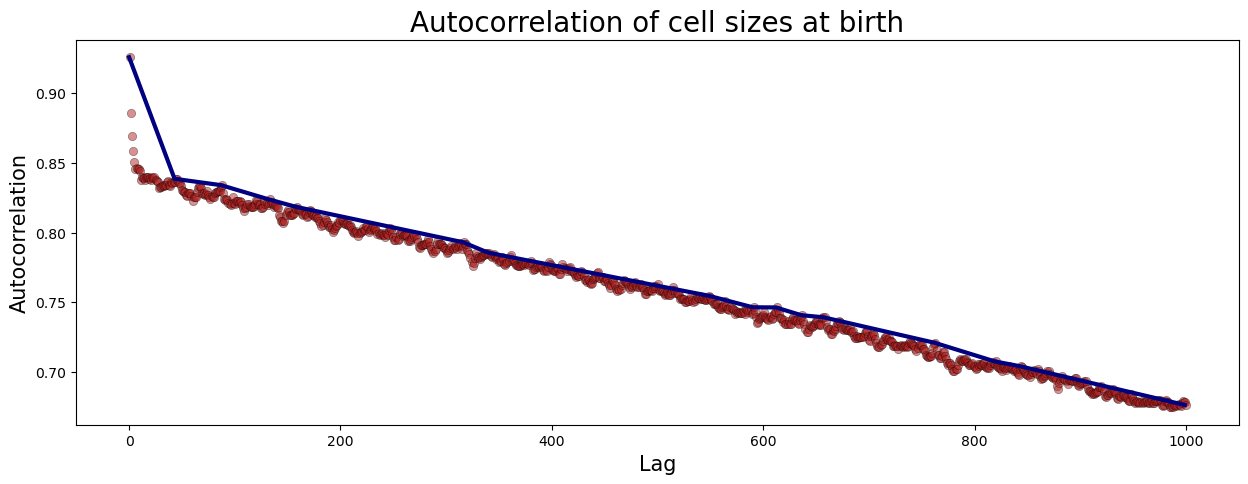

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
q_u = np.zeros(cGt.shape)

#Prepend the first value of (s) to the interpolating values

u_x = [0,]
u_y = [cGt[0],]


#Detect peaks  and mark their location in u_x,u_y

for k in range(1,len(cGt)-20):
    signRange = [(np.sign(cGt[k]-cGt[k-i])==1, np.sign(cGt[k]-cGt[k+i])==1) for i in range(1,20)]
    if all(list(map(lambda x: (x[0] and x[1]), signRange))):
        u_x.append(k)
        u_y.append(cGt[k])


#Append the last value of to the interpolating values


u_x.append(len(cGt)-1)
u_y.append(cGt[-1])



u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)

#Evaluate each model over the domain of (s)
for k in range(0,len(cGt)):
    q_u[k] = u_p(k)
    
ax.plot(u_x, u_y, color = 'navy', linewidth = 3)
#ax.plot(q_u, color = 'forestgreen', linewidth = 3)
ax.scatter(lagsGt, cGt, color = 'firebrick', alpha = 0.5, edgecolor = 'black', linewidth = 0.4)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

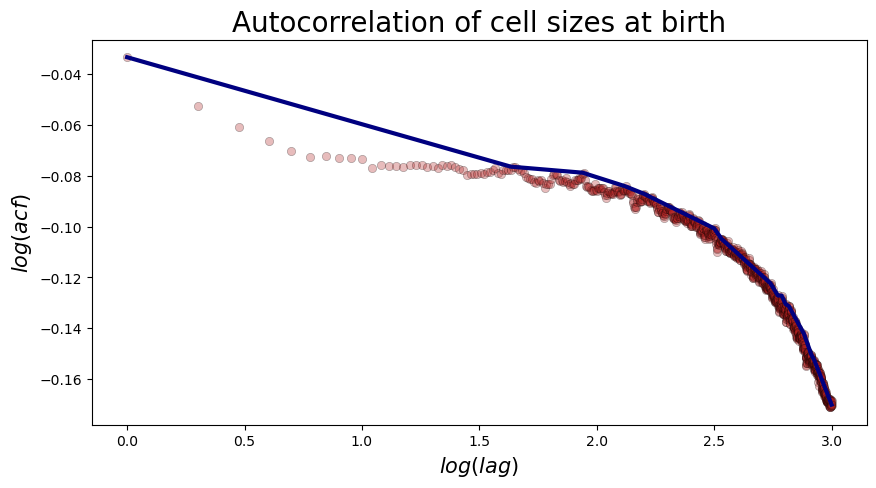

In [ ]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
ax.set_xlim(left = -0.1)
plt.cla()
ax.scatter(np.log10(lagsGt), np.log10(cGt), color = 'firebrick', edgecolor = 'black', alpha = 0.3, linewidth = 0.5)
#ax.plot(q_u, color = 'forestgreen', linewidth = 3)
ax.plot(np.log10([lagsGt[0]] + list(u_x[1:])), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)

#slope, intercept, r, p, se = linregress(np.log10(lagsGt), np.log10(cGt))
#ax.plot(np.log10(lagsGt), slope*np.log10(lagsGt) + intercept, color = 'forestgreen', linewidth = 3)
ax.set_xlabel('$log(lag)$', fontsize = 15)
ax.set_ylabel('$log(acf)$', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

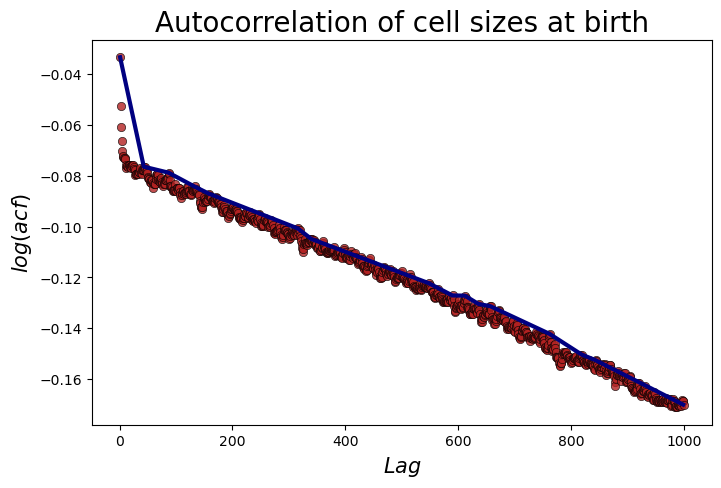

In [ ]:

fig, ax = plt.subplots(1, 1, figsize = (8, 5))
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
ax.set_xlim(left = -0.1)
plt.cla()
ax.scatter(lags[lags > 0], np.log10(c[lags > 0]), color = 'firebrick', edgecolor = 'black', alpha = 0.8, linewidth = 0.5)
ax.plot([lagsGt[0]] + list(u_x[1:]), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)
ax.set_xlabel('$Lag$', fontsize = 15)
ax.set_ylabel('$log(acf)$', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

## Model 1

$$
g(x) = \omega_1 x
$$

$$
h(x) = \begin{cases}
0, & x < u \\
\omega_2 \cdot \dfrac{x + v}{u + v},& x \geq u
\end{cases}
$$

$$ 
x(t) = x_b \cdot e^{\omega_1 t} \
$$
$$
\ln(s(t)) = - \left[ \dfrac{x_b}{u+v} \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{v}{u+v}, \omega_2 (t-t_0) \right] \theta(t-t_0) \
$$
$$
s(t) = \exp{ \left\{- \left[ \dfrac{x_b}{ u+v } \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{v}{u+v}, \omega_2 (t-t_0) \right] \theta(t-t_0) \right\}}
$$
\
\
\
Where,
$$
t_0 \equiv max \left\{ 0, \dfrac{1}{\omega_1}ln\left( \dfrac{u}{x_b} \right)  \right\}
$$

In [15]:
'''
Hazard rate function h(t)
'''

def hModel1(t, omega2, u, xb, omega1 = 1, v = 1):
    h_ = omega2*((x_function(t, u, xb, omega1) + v)/(u+v)) # if x(t) ≥ mu
    h_[x_function(t, u, xb, omega1)] = 0                   # if x(t) < mu
    
    return h_


'''
Logarithm of survival function s(t) for a float t
'''
def log_SDF_float(t, omega2, u, xb, omega1 = 1, v = 1):

    # threshold time
    t0 = max([0, ((1.0/omega1) * np.log(u/xb))])

    if t>=t0:
        ln_s_ = - ( (xb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    (v/(u+v)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0

    return ln_s_


'''
Logarithm of survival function s(t) for an array t
'''
def log_SDF_arr(t, omega2, u, xb, omega1 = 1, v = 1):

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(u/xb)])
    
    ln_s_ = - ( (xb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) + (v/(u+v)) * omega2 * (t-t0) )
    ln_s_[t < t0] = 0                 # if x(t) < mu

    return ln_s_

    
'''
Logarithm of survival function s(t)
'''
def log_SDF(t, omega2, u, xb, omega1 = 1, v = 1):
    

    if type(t) == np.ndarray: # array
        ln_s_ = log_SDF_arr(t, omega2, u, xb, omega1, v)
    else: # float
        ln_s_ = log_SDF_float(t, omega2, u, xb, omega1, v)

    return ln_s_


'''
Survival function s(t)
'''
def SDF(t, omega2, u, xb, omega1 = 1, v = 1):
    return np.exp(log_SDF(t, omega2, u, xb, omega1, v))


'''
Find tau numerically
'''
def draw_tau_numerical(K, omega2, u, xb, omega1 = 1, v = 1):
    

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(u/xb)])
    
    t_max = 9/omega1 # approx. 100 tau to avoid roundoff error

    sol = root_scalar(lambda t: SDF(t, omega2, u, xb, omega1, v) - K, bracket=[0, 40], method='brentq')
    tau = sol.root
    
    return tau

In [16]:
seriesLength = 5000 # Length of the time series
pointsPerEvolution = 200 # Number of points per cell division
sizesAtBirth = np.zeros(seriesLength)
timesAtBirth = np.zeros(seriesLength)
u = .9
omega2 = 0.01

# Initialize the cell size array
cellSizes = np.zeros(pointsPerEvolution*seriesLength)
xb = 0.5
t = 0
for i in range(seriesLength):
    timesAtBirth[i] = t
    tau = draw_tau_numerical(np.random.uniform(0, 1), omega2, u, xb)
    times = np.linspace(0, tau, pointsPerEvolution)
    xt = x_function(times, u = 0.1, xb = xb, omega1 = 1)
    cellSizes[i*pointsPerEvolution:(i+1)*pointsPerEvolution] = xt
    sizesAtBirth[i] = xb
    xb = xt[-1]/2
    t += tau


allTimes = np.linspace(0, t, pointsPerEvolution*seriesLength)

NameError: name 'x_function' is not defined

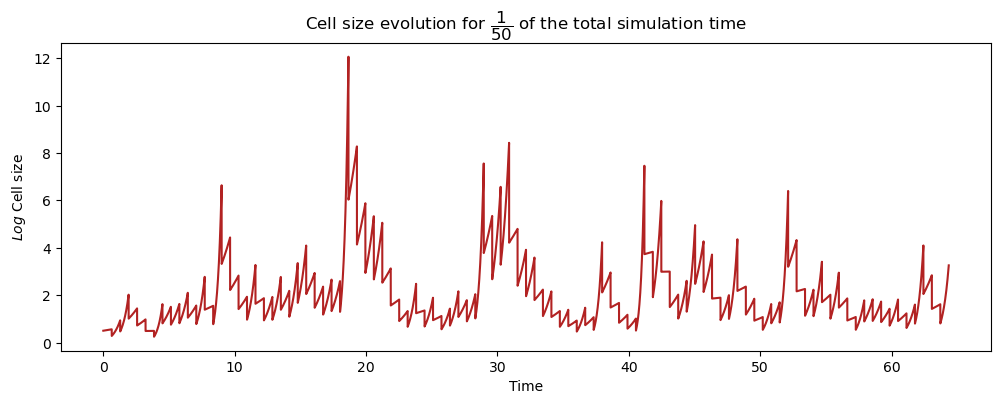

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
ax.plot(allTimes[:int(len(allTimes)/50)], cellSizes[:int(len(allTimes)/50)], color = 'firebrick')
ax.set_ylabel('$Log$ Cell size')
ax.set_xlabel('Time')
ax.set_title('Cell size evolution for $\dfrac{1}{50}$ of the total simulation time')
plt.show()

Dominant frequency: 0.0640


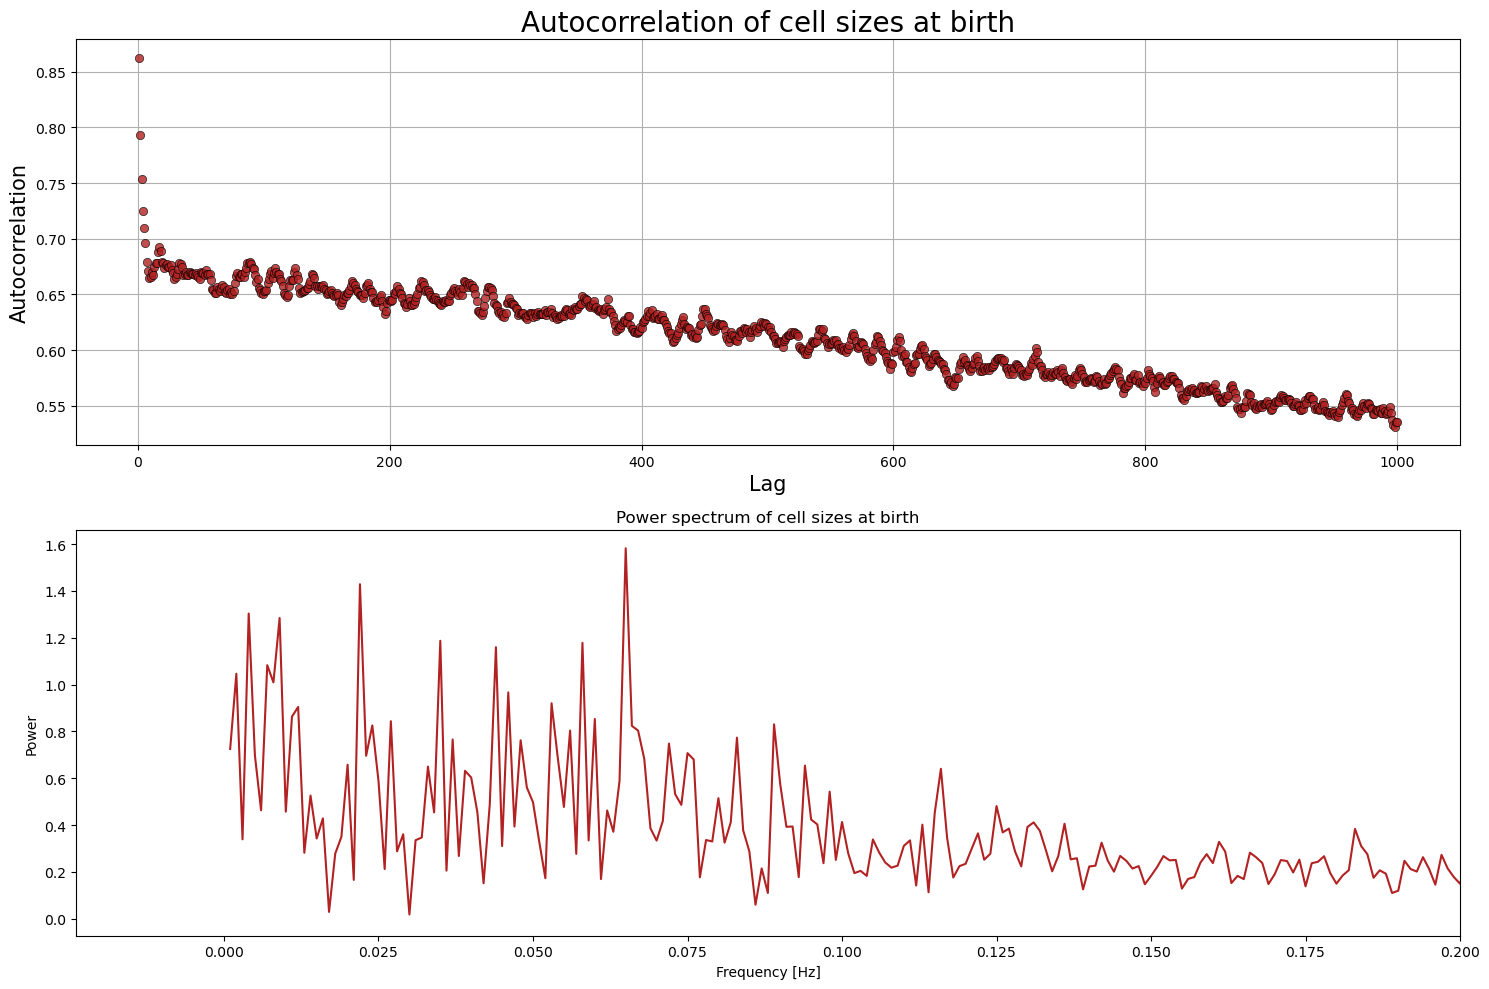

In [10]:
fig, ax1 = plt.subplots(2, 1, figsize = (15, 10))
ax, ax_ = ax1.flatten()
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
#ax.set_xlim(left = -0.1)
plt.cla()
lagsGt = lags[lags > 0]
cGt = c[lags > 0]
ax.scatter(lagsGt, cGt, color = 'firebrick', alpha = 0.8, edgecolor = 'black', linewidth = 0.5, zorder = 2)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
ax.grid(zorder = 1)

# The FFT of the signal
sig_fft = fftpack.fft(detrend(cGt))

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)



# The return the corresponding frequencies
sample_freq = fftpack.fftfreq(len(cGt), d = 1)
#print(sample_freq[power.argmax()])

# Plot the FFT power
ax_.plot(sample_freq[sample_freq > 0], power[sample_freq > 0], color = 'firebrick')
ax_.set_xlabel('Frequency [Hz]')
ax_.set_ylabel('Power')
ax_.set_title('Power spectrum of cell sizes at birth')
ax_.set_xlim(right = 0.2)
print(f'Dominant frequency: {sample_freq[np.argmax(power[sample_freq > 0])]:.4f}')
fig.tight_layout()

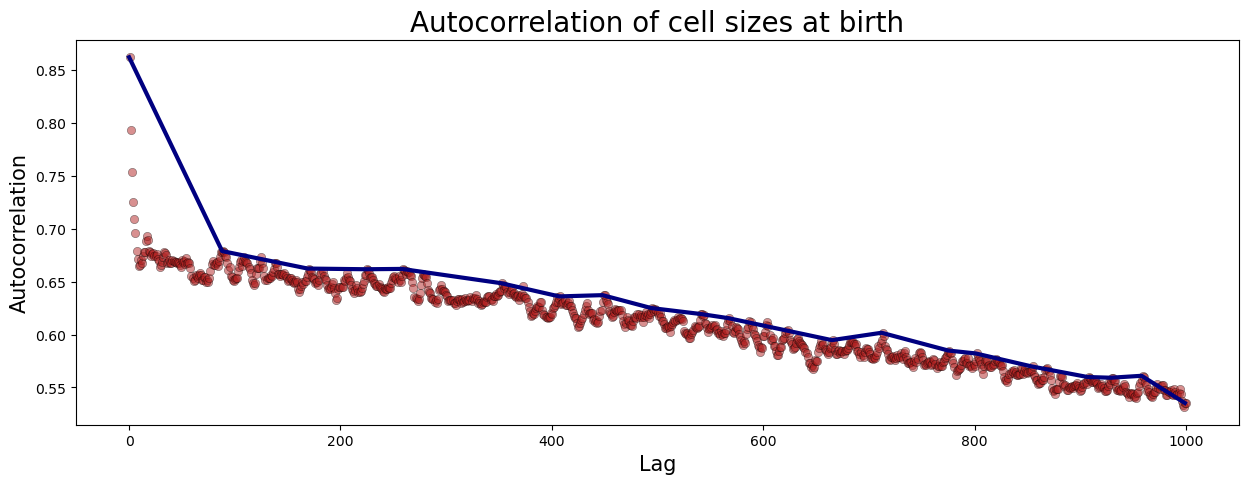

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
q_u = np.zeros(cGt.shape)

#Prepend the first value of (s) to the interpolating values

u_x = [0,]
u_y = [cGt[0],]


#Detect peaks  and mark their location in u_x,u_y

for k in range(1,len(cGt)-20):
    signRange = [(np.sign(cGt[k]-cGt[k-i])==1, np.sign(cGt[k]-cGt[k+i])==1) for i in range(1,20)]
    if all(list(map(lambda x: (x[0] and x[1]), signRange))):
        u_x.append(k)
        u_y.append(cGt[k])


#Append the last value of to the interpolating values


u_x.append(len(cGt)-1)
u_y.append(cGt[-1])



u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)

#Evaluate each model over the domain of (s)
for k in range(0,len(cGt)):
    q_u[k] = u_p(k)
    
ax.plot(u_x, u_y, color = 'navy', linewidth = 3)
#ax.plot(q_u, color = 'forestgreen', linewidth = 3)
ax.scatter(lagsGt, cGt, color = 'firebrick', alpha = 0.5, edgecolor = 'black', linewidth = 0.4)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

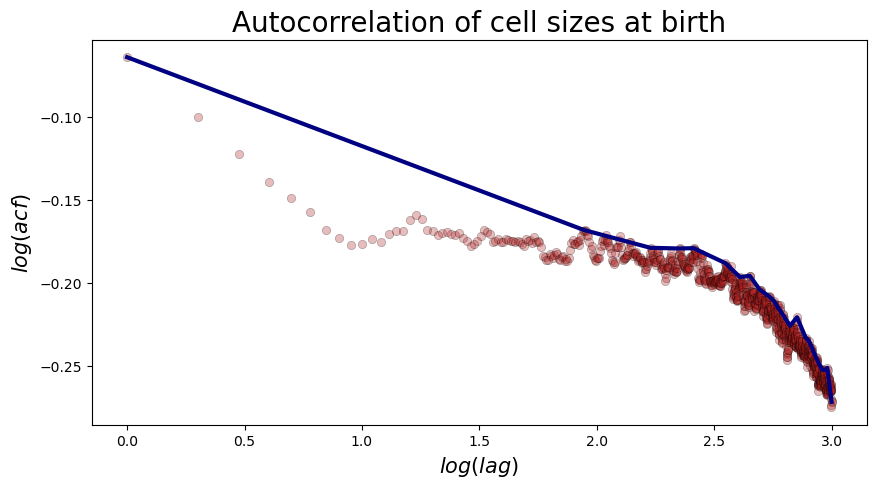

In [12]:

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
ax.set_xlim(left = -0.1)
plt.cla()
ax.scatter(np.log10(lagsGt), np.log10(cGt), color = 'firebrick', edgecolor = 'black', alpha = 0.3, linewidth = 0.5)
#ax.plot(q_u, color = 'forestgreen', linewidth = 3)
ax.plot(np.log10([lagsGt[0]] + list(u_x[1:])), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)

#slope, intercept, r, p, se = linregress(np.log10(lagsGt), np.log10(cGt))
#ax.plot(np.log10(lagsGt), slope*np.log10(lagsGt) + intercept, color = 'forestgreen', linewidth = 3)
ax.set_xlabel('$log(lag)$', fontsize = 15)
ax.set_ylabel('$log(acf)$', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

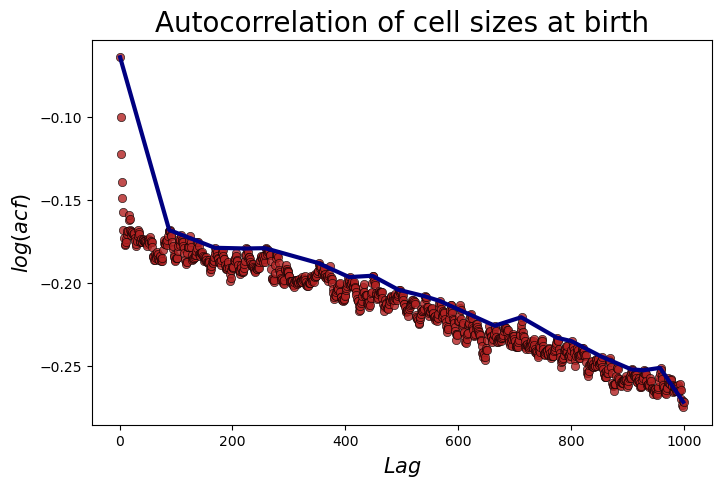

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
ax.set_xlim(left = -0.1)
plt.cla()
ax.scatter(lags[lags > 0], np.log10(c[lags > 0]), color = 'firebrick', edgecolor = 'black', alpha = 0.8, linewidth = 0.5)
ax.plot([lagsGt[0]] + list(u_x[1:]), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)
ax.set_xlabel('$Lag$', fontsize = 15)
ax.set_ylabel('$log(acf)$', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

# Model 3 - Two trait models
The main difference between this model and the previous ones is that here we consider 2 traits: the cell size $m(t)$ and its protein content $p(t)$. We call $\bar{x}$ the vector
$$
\bar{x} = \begin{pmatrix} m\\ p\end{pmatrix} 
$$

As before, the traits evolution and the cell division are governed by $g(\bar{x})$ and $h(p)$ respectively, which are defined as 
$$
\begin{aligned}
g(\bar{x})&=\omega_1m \cdot \begin{pmatrix} 1\\ c\end{pmatrix} \\
h(p)&=
    \begin{cases}
    0   & , \, p<u \\
    \omega_2 \, \frac{p+v}{u+v} & , \, p\geq u
    \end{cases}
\end{aligned}
$$
From $g(\bar{x})$ we can notice that the cell size still grows exponentially and the protein content also follows this evolution, scaled by the factor $c$. As $c$ doesn't have a real meaning, we set it to $1$. 

Moreover, in this model the condition under which the cell can divide is that it contains a minimum amount of a specific type of protein, which we call $u$. If $p\geq u$ the cell can divide, otherwise it cannot. Unlike [model 1](model_1.ipynb), we do not have any conditions on the size of the cell for the division to take place and $h$ depens only on $p$.

The initial conditions for $m(t)$ and $p(t)$ are
$$
\begin{aligned}
    p(t=0) &= 0 \\
    m(t=0) &= m_b
\end{aligned}
$$

The division process in this model occurs in the following way
$$
\begin{pmatrix} m \\ p\end{pmatrix} \rightarrow \begin{pmatrix} \text{f}  m \\ 0\end{pmatrix} + \begin{pmatrix} (1-\text{f}) \cdot m \\ 0\end{pmatrix}
$$
where for now we keep $\text{f}=0.5$.


## Analytical solution of the differential equations
The results of the two differential equations are:
$$
\begin{aligned}

m(t) &= m_b\, e^{\omega_1 t} \\
\\
p(t) &= m_b\, \left(e^{\omega_1 t}-1 \right) \quad \quad (\text{Assuming, }c=1)  \\
\\
\ln(s(t)) &= - \left[ \dfrac{m_b}{u+v} \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{v - m_b}{u+v}\, \omega_2 (t-t_0) \right] \theta   (t-t_0) \\




%s(t) &= \exp\left\{ - \left[ \dfrac{m_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left.         %(e^\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu - m_b}{\mu+\nu}\, \omega_2 (t-t_0) %\right] \theta(t-t_0) \right\}



\end{aligned}

$$

where $t_0 \equiv \dfrac{1}{\omega_1} \ln\left(1 + \dfrac{u}{m_b}\right) $ is the minimum time at which the cell can divide and $\theta(\tau)$ is the Heaviside function.



In [21]:
'''
Cell size evolution m(t)
'''
def m_function(t, mb, omega1 = 1, v = 1):
    

    m_ = (mb)*np.exp(omega1*t)
    return m_


'''
Protein content evolution p(t)
'''
def p_function(t, mb, omega1 = 1, v = 1):
    

    
    p_ = (mb)*(np.exp(omega1*t) - 1)
    return p_


'''
Hazard rate function h(t)
'''
def h(t, mb, u, omega2, omega1 = 1, v = 1):

    h_ = omega2*((p_function(t, mb, omega1, v) + v)/(u+v))          # if p(t) ≥ mu
    h_[p_function(t, mb, omega1 = 1, v = 1) < u] = 0                 # if p(t) < mu
    
    return h_


'''
Logarithm of survival function s(t) for a float t
'''
def log_CDF_float(t, mb, u, omega2, omega1 = 1, v = 1):
    

    # threshold time
    #t0 = (1.0/omega1) * np.log(1 + (u/mb))
    t0 = max([0, (1.0/omega1) * np.log(1 + (u/mb))])
    if t>=t0:
        ln_s_ = - ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    ((v-mb)/(u+v)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0

    return ln_s_


'''
Logarithm of survival function s(t) for an array t
'''
# threshold time

def log_CDF_arr(t, mb, u, omega2, omega1 = 1, v = 1):
    

    t0 = (1.0/omega1) * np.log(1 + (u/mb))
    

    ln_s_ = - ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((v-mb)/(u+v)) * omega2 * (t-t0) )
    
    
    
    ln_s_[t < t0] = 0                 # if p(t) < mu

    return ln_s_


'''
Logarithm of survival function s(t)
'''
def log_CDF(t, mb, u, omega2, omega1 = 1, v = 1):

    if type(t) == np.ndarray: # array
        ln_s_ = log_CDF_arr(t, mb, u, omega2, omega1, v)
    else: # float
        ln_s_ = log_CDF_float(t, mb, u, omega2, omega1, v)

    return ln_s_

def CDF2(t, mb, u, omega2, omega1 = 1, v = 1):
    return np.exp(- ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t) - 1) +((v-mb)/(u+v)) * omega2 * (t) ))

'''
Survival function s(t)
'''
def CDF(t, mb, u, omega2, omega1 = 1, v = 1):
    return np.exp(log_CDF(t, mb, u, omega2, omega1, v))

'''
Find tau numerically
'''
def draw_tau_numerical(K, mb, u, omega2, omega1 = 1, v = 1):
    

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(1 + (u/mb))])

    sol = root_scalar(lambda t: CDF(t, mb = mb, u = u, omega2 = omega2, omega1 = omega1, v = v) - K, bracket=[t0, 40], method='brentq')
    tau = sol.root
    
    return tau



In [11]:
#plt.plot(CDF2(np.linspace(0, 10, 100), mb = 0.5, u = 0,omega2 =  0.1, omega1 = 1, v =  1))
#plt.xlim(0, 15)

In [31]:
seriesLength = 5000 # Length of the time series
pointsPerEvolution = 200 # Number of points per cell division
sizesAtBirth = np.zeros(seriesLength)
timesAtBirth = np.zeros(seriesLength)

s_drawn = np.random.uniform(low=0, high = 1, size = seriesLength)
ln_s_drawn = np.log(s_drawn)
# Initialize the cell size array
cellSizes = np.zeros(pointsPerEvolution*seriesLength)
mb = 0.9
t = 0
u = .9
omega2 = (1 / np.log(2)) + .01
for i in range(seriesLength): 
    sizesAtBirth[i] = mb
    #parameters = (1,0.9,0.1,1,mb) # omega1, omega2, mu, nu, xb
    tau = draw_tau_numerical(s_drawn[i],  mb = mb, u = u, omega2 = omega2, omega1 = 1, v = 1)
    #sim_t.append(tau)

    # evolution
    times = np.linspace(0, tau, pointsPerEvolution)
    mt = m_function(times,  mb = mb, omega1 = 1, v = 1)
    # pt = p_function(times, parameters)
    
    # store times and sizes
    #all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
    cellSizes[i*pointsPerEvolution : (i+1)*pointsPerEvolution] = mt

    # update the initial time and the starting size
    mb = mt[-1]*(1/2)
    t = t+tau

allTimes = np.linspace(0, t, pointsPerEvolution*seriesLength)

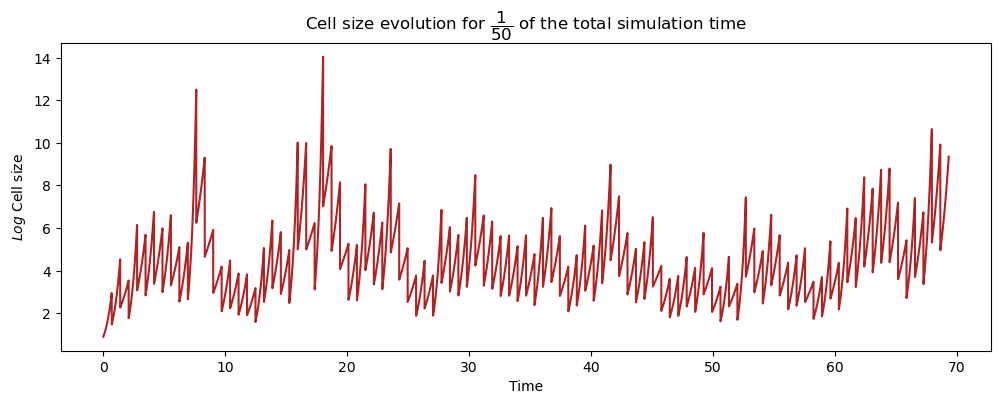

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
ax.plot(allTimes[:int(len(allTimes)/50)], cellSizes[:int(len(allTimes)/50)], color = 'firebrick')
ax.set_ylabel('$Log$ Cell size')
ax.set_xlabel('Time')
ax.set_title('Cell size evolution for $\dfrac{1}{50}$ of the total simulation time')
plt.show()

Dominant frequency: 0.0120


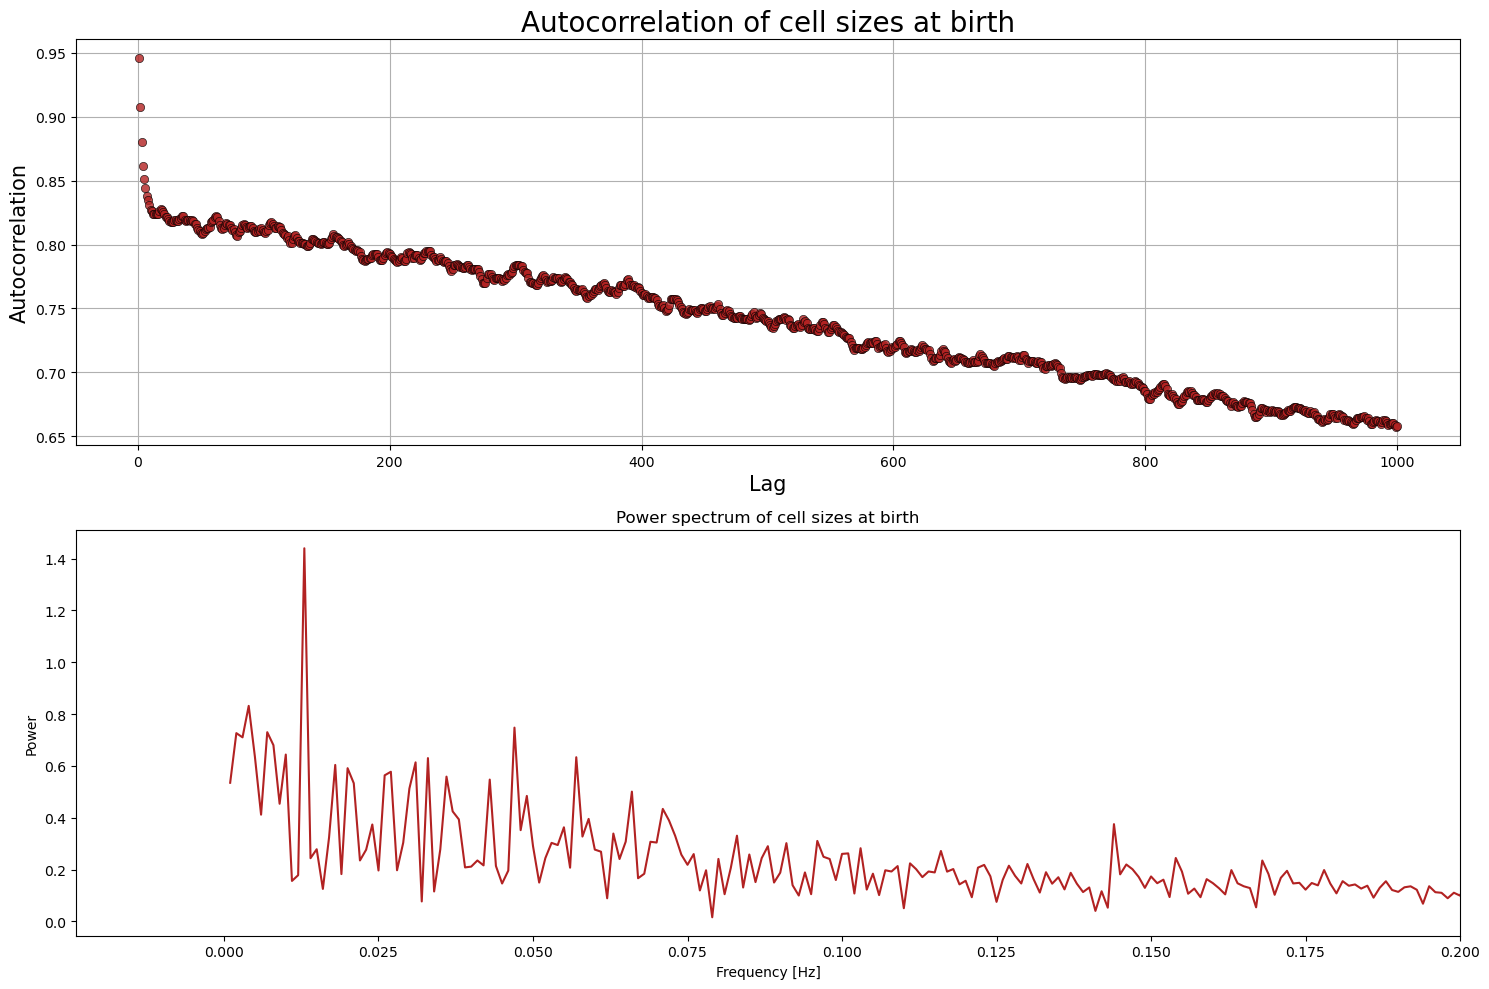

In [6]:
fig, ax1 = plt.subplots(2, 1, figsize = (15, 10))
ax, ax_ = ax1.flatten()
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
#ax.set_xlim(left = -0.1)
plt.cla()
lagsGt = lags[lags > 0]
cGt = c[lags > 0]
ax.scatter(lagsGt, cGt, color = 'firebrick', alpha = 0.8, edgecolor = 'black', linewidth = 0.5, zorder = 2)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
ax.grid(zorder = 1)

# The FFT of the signal
sig_fft = fftpack.fft(detrend(cGt))

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)



# Return the corresponding frequencies
sample_freq = fftpack.fftfreq(len(cGt), d = 1)


# Plot the FFT power
ax_.plot(sample_freq[sample_freq > 0], power[sample_freq > 0], color = 'firebrick')
ax_.set_xlabel('Frequency [Hz]')
ax_.set_ylabel('Power')
ax_.set_title('Power spectrum of cell sizes at birth')
ax_.set_xlim(right = 0.2)
print(f'Dominant frequency: {sample_freq[np.argmax(power[sample_freq > 0])]:.4f}')
fig.tight_layout()

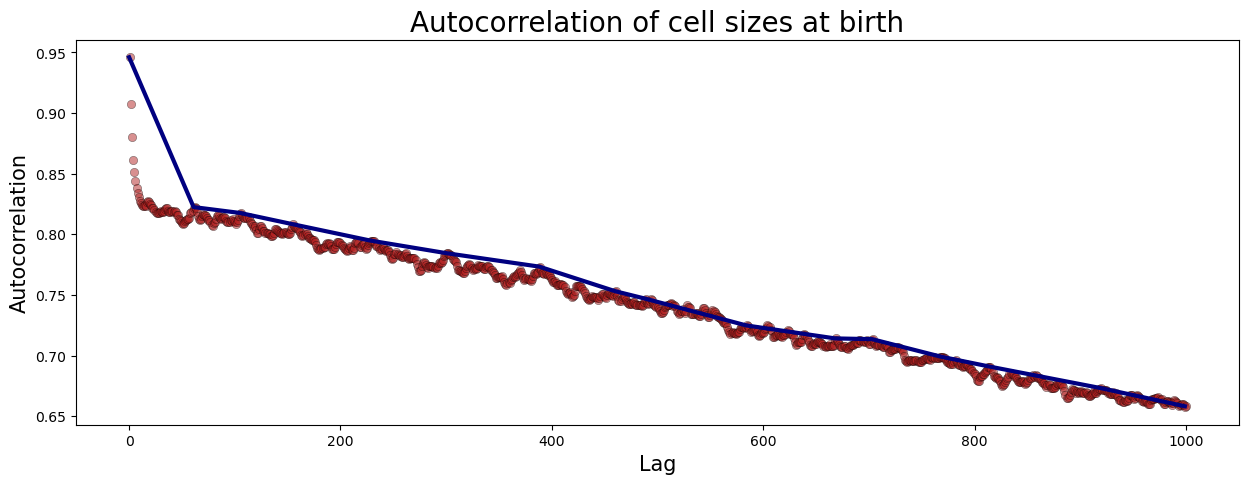

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
q_u = np.zeros(cGt.shape)

#Prepend the first value of (s) to the interpolating values

u_x = [0,]
u_y = [cGt[0],]


#Detect peaks  and mark their location in u_x,u_y

for k in range(1,len(cGt)-20):
    signRange = [(np.sign(cGt[k]-cGt[k-i])==1, np.sign(cGt[k]-cGt[k+i])==1) for i in range(1,20)]
    if all(list(map(lambda x: (x[0] and x[1]), signRange))):
        u_x.append(k)
        u_y.append(cGt[k])


#Append the last value of to the interpolating values


u_x.append(len(cGt)-1)
u_y.append(cGt[-1])



u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)

#Evaluate each model over the domain of (s)
for k in range(0,len(cGt)):
    q_u[k] = u_p(k)
    
ax.plot(u_x, u_y, color = 'navy', linewidth = 3)
#ax.plot(q_u, color = 'forestgreen', linewidth = 3)
ax.scatter(lagsGt, cGt, color = 'firebrick', alpha = 0.5, edgecolor = 'black', linewidth = 0.4)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

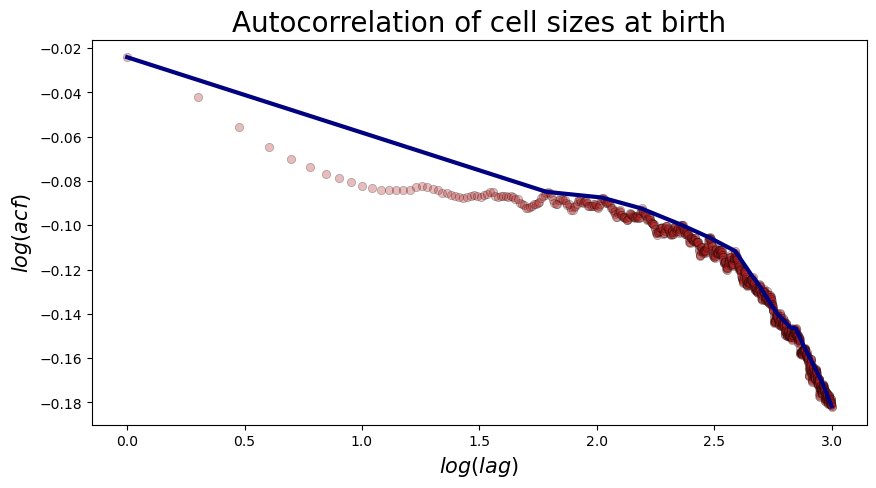

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
ax.set_xlim(left = -0.1)
plt.cla()
ax.scatter(np.log10(lagsGt), np.log10(cGt), color = 'firebrick', edgecolor = 'black', alpha = 0.3, linewidth = 0.5)
#ax.plot(q_u, color = 'forestgreen', linewidth = 3)
ax.plot(np.log10([lagsGt[0]] + list(u_x[1:])), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)

#slope, intercept, r, p, se = linregress(np.log10(lagsGt), np.log10(cGt))
#ax.plot(np.log10(lagsGt), slope*np.log10(lagsGt) + intercept, color = 'forestgreen', linewidth = 3)
ax.set_xlabel('$log(lag)$', fontsize = 15)
ax.set_ylabel('$log(acf)$', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
plt.show()

Autocorrelation: 3603.10028541061


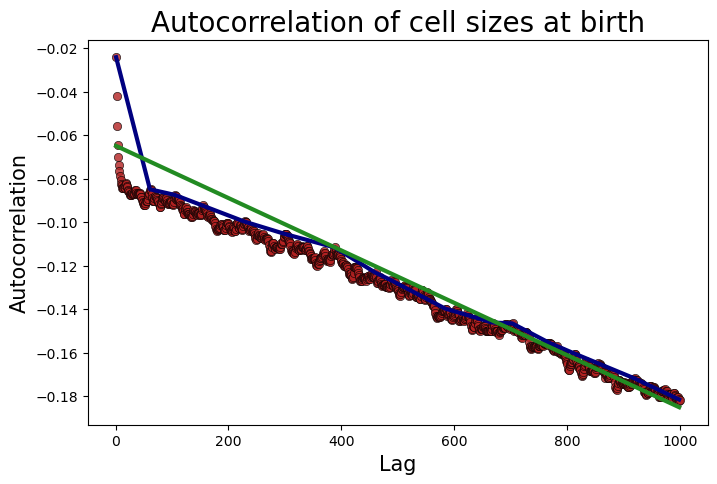

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = 1000, color = 'firebrick', usevlines = False, normed = True)
ax.set_xlim(left = -0.1)
plt.cla()
ax.scatter(lags[lags > 0], np.log10(c[lags > 0]), color = 'firebrick', edgecolor = 'black', alpha = 0.8, linewidth = 0.5)
ax.plot([lagsGt[0]] + list(u_x[1:]), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)
slope, intercept, r, p, se = linregress(u_x[0:], np.log10(u_y[0:]))
ax.plot([lagsGt[0]] + list(u_x[1:]), slope*np.array([lagsGt[0]] + list(u_x[1:])) + intercept, color = 'forestgreen', linewidth = 3)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Autocorrelation', fontsize = 15)
ax.set_title('Autocorrelation of cell sizes at birth', fontsize = 20)
print('Autocorrelation:', -np.log10(np.exp(1))/slope)
plt.show()